# GNN Link Prediction with MiniLM
with graph Laplacian regularization

In [1]:
!wget https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/reviews_anonymized_fulltext.csv
!wget https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/genre_group.p

--2024-08-20 02:58:23--  https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/reviews_anonymized_fulltext.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98893894 (94M) [text/plain]
Saving to: ‘reviews_anonymized_fulltext.csv’

reviews_anonymized_ 100%[===================>]  94.31M   170MB/s    in 0.6s    

2024-08-20 02:58:26 (170 MB/s) - ‘reviews_anonymized_fulltext.csv’ saved [98893894/98893894]

--2024-08-20 02:58:27--  https://raw.githubusercontent.com/jzh001/GNNs/main/metal_music_reviews/genre_group.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP req

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 233.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch

In [4]:
full_df = pd.read_csv('/content/reviews_anonymized_fulltext.csv')
full_df

,User,Release,Combined_Genre,Score,Review_title,Cleansed Text
0,0,847,death metal|thrash metal,100,GHOUL - We Came For The Dead !!!,GHOUL - We Came For The Dead !!! Wow ! This is...
1,1,848,heavy metal|us power metal,65,Warriors of the World,Here we are. The first studio release from Man...
2,1,849,symphonic power metal,90,Best Rhapsody album to date,"One look at the artwork, the title and the tra..."
3,1,850,heavy metal,90,Rock In Rio,Another Iron Maiden live album? This is the fi...
4,1,851,power metal,80,Blind Guardian - A Night At the Opera,"The epic, Tolkien-inspired ""Nightfall In Middl..."
...,...,...,...,...,...,...
28487,589,3247,hard rock,86,Compositional defiance,There seems to be a weird hype about Taken by ...
28488,376,3062,thrash metal,85,"Take your life back, in the pit!",I don't have any issues with the retro-thrash ...
28489,376,4244,death metal,65,As mediocre as it's predecessor,Aeon’s brand of death metal is supposed to be ...
28490,376,2447,thrash metal,80,Officers are dirtier than the criminals they c...,This band was so important for the thrash meta...


In [5]:
all_users = full_df['User'].unique()
all_releases = full_df['Release'].unique()

N_USERS = len(all_users)
N_RELEASES = len(all_releases)
N_ENTRIES = len(full_df)

N_USERS, N_RELEASES, N_ENTRIES

(847, 4238, 28492)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
from transformers import AutoModel, AutoTokenizer

model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# Load pre-trained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name)

text_model.to(device)

# Freeze all the parameters
for param in text_model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch

def get_bow_features(texts, max_features=5000):
    """
    Generate Bag of Words features for the input texts.
    """
    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(texts)
    bow_features = X.toarray()

    bow_features = torch.tensor(bow_features, dtype=torch.float32)
    print("BoW Feature Shape:", bow_features.shape)

    return bow_features

In [9]:
from tqdm import tqdm

def get_text_features(texts, batch_size=128):
    all_pooled = []

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        with torch.no_grad():
            batch_texts = texts[i:i + batch_size]

            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            outputs = text_model(**inputs)
            embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]
            pooled = torch.mean(embeddings, dim=1)  # Shape: [batch_size, hidden_dim]

            all_pooled.append(pooled)

    # Concatenate all the pooled embeddings
    all_pooled = torch.cat(all_pooled, dim=0)  # Shape: [total_texts, hidden_dim]
    print("Text Feature Shape:", all_pooled.shape)
    return all_pooled.detach()

def generate_node_features(df):
    '''
    Generate node features based on review text generated by user
    '''
    user_texts = [""] * N_USERS
    for _,row in df.iterrows():
        user_texts[row['User']] += row['Review_title'] + '. ' + row['Cleansed Text'] + ' '

    return get_text_features(user_texts)
    # return get_bow_features(user_texts)

In [10]:
import networkx as nx

def generate_edges(df):
    B = nx.Graph() # Bipartite Graph
    for _,row in df.iterrows():
        B.add_edge(row['User'], row['Release'])

    edge_index = []

    for u in all_users:
        for release in B.adj[u]:
            for v in B.adj[release]:
                if u != v:
                  edge_index.append([u, v])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    print("Number of bidirectional edges:", edge_index.shape[1] / 2)
    print("Number of nodes:", N_USERS)
    print("Edge Density (probability of positive edge):", (edge_index.shape[1] / 2) / (N_USERS * (N_USERS - 1)))

    return edge_index


In [11]:
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges

def process_data(df):
    X = generate_node_features(df)
    edge_index = generate_edges(df)
    return Data(x=X, edge_index=edge_index)

def split_data(data, val_ratio=0.2):
    data = train_test_split_edges(data, val_ratio=val_ratio)
    return data

In [12]:
data = process_data(full_df)
data = split_data(data)

100%|██████████| 7/7 [01:23<00:00, 11.92s/it]


Text Feature Shape: torch.Size([847, 384])
Number of bidirectional edges: 107866.0
Number of nodes: 847
Edge Density (probability of positive edge): 0.15053268244757606


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [13]:
data

Data(x=[847, 384], val_pos_edge_index=[2, 21573], test_pos_edge_index=[2, 10786], train_pos_edge_index=[2, 76424], train_neg_adj_mask=[847, 847], val_neg_edge_index=[2, 21573], test_neg_edge_index=[2, 10786])

In [14]:
from torch_geometric.utils import to_dense_adj

def laplacian_regularization(z, edge_index, lambda_reg=1e-3):
    adj = to_dense_adj(edge_index).squeeze()
    diff = z.unsqueeze(1) - z.unsqueeze(0)
    diff_squared = diff.pow(2).sum(-1)
    laplacian_loss = (adj * diff_squared).mean()
    return lambda_reg * laplacian_loss

In [23]:
from torch import nn
from torch_geometric.nn import GCNConv, GATConv, GatedGraphConv
from torch_geometric.utils import negative_sampling

class GCNConvBlock(nn.Module):
    def __init__(self, hidden_size, dropout_prob):
        super(GCNConvBlock, self).__init__()
        self.conv1 = GCNConv(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, edge_index):
        residual = x
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.layer_norm1(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = x + residual
        x = self.relu(x)
        x = self.layer_norm2(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = x + residual
        x = self.relu(x)
        return x

class GATConvBlock(nn.Module):
    def __init__(self, hidden_size, dropout_prob, n_heads=8):
        super(GATConvBlock, self).__init__()
        self.conv1 = GATConv(hidden_size, hidden_size // n_heads, heads=n_heads)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.conv2 = GATConv(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, edge_index):
        residual = x
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.layer_norm1(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = x + residual
        x = self.relu(x)
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size=512, dropout_prob=0.5):
        super(GNN, self).__init__()
        self.initial_conv = GCNConv(in_channels, hidden_size)
        self.layer_norm_initial = nn.LayerNorm(hidden_size)

        self.gcn1 = GCNConvBlock(hidden_size, dropout_prob)
        self.gcn2 = GCNConvBlock(hidden_size, dropout_prob)
        self.gcn3 = GCNConvBlock(hidden_size, dropout_prob)
        self.gat1 = GATConvBlock(hidden_size, dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_channels)
        )

        self.relu = nn.ReLU()

    def encode(self, x, edge_index):
        x = self.initial_conv(x, edge_index)
        x = self.relu(x)
        x = self.layer_norm_initial(x)
        residual = x
        x = self.gcn1(x, edge_index)
        x = x + residual
        x = self.gcn2(x, edge_index)
        x = x + residual
        x = self.gcn3(x, edge_index)
        x = x + residual
        x = self.gat1(x, edge_index)
        return x

    def decode(self, z, edge_index):
        u, v = edge_index
        edge_features = torch.cat([z[u], z[v]], dim=1)
        return self.mlp(edge_features)

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        recon = self.decode(z, edge_label_index)
        return recon, z  # Return both reconstruction and embeddings for the regularization term

In [24]:
model = GNN(data.x.shape[1], 1)
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (initial_conv): GCNConv(384, 512)
  (layer_norm_initial): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (gcn1): GCNConvBlock(
    (conv1): GCNConv(512, 512)
    (relu): ReLU()
    (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (conv2): GCNConv(512, 512)
    (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (conv3): GCNConv(512, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (gcn2): GCNConvBlock(
    (conv1): GCNConv(512, 512)
    (relu): ReLU()
    (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (conv2): GCNConv(512, 512)
    (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (conv3): GCNConv(512, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (gcn3): GCNConvBlock(
    (conv1): GCNConv(512, 512)
    (relu): ReLU()
    (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (conv2): GCNConv(512, 512)
    (layer_norm2): LayerNorm((512,), eps=

In [25]:
def train():
    model.train()
    optimizer.zero_grad()

    data.to(device)

    out, z = model(data.x, data.train_pos_edge_index, data.train_pos_edge_index)

    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=data.train_pos_edge_index.size(1))
    neg_out, _ = model(data.x, data.train_pos_edge_index, neg_edge_index)

    pos_loss = loss_fn(out.squeeze(1), torch.ones(out.size(0)).to(device))
    neg_loss = loss_fn(neg_out.squeeze(1), torch.zeros(neg_out.size(0)).to(device))

    laplacian_loss = laplacian_regularization(z, data.train_pos_edge_index)

    loss = pos_loss + neg_loss + laplacian_loss

    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        pos_out = model.decode(z, data.test_pos_edge_index)
        neg_out = model.decode(z, data.test_neg_edge_index)

        pos_loss = loss_fn(pos_out.squeeze(1), torch.ones(pos_out.size(0)).to(device))
        neg_loss = loss_fn(neg_out.squeeze(1), torch.zeros(neg_out.size(0)).to(device))

        # Compute Laplacian regularization loss (optional during testing)
        laplacian_loss = laplacian_regularization(z, data.train_pos_edge_index)

        loss = pos_loss + neg_loss + laplacian_loss

        pos_pred = (pos_out > 0).float()
        neg_pred = (neg_out > 0).float()

        pos_acc = pos_pred.sum().item() / pos_pred.size(0)
        neg_acc = (neg_pred == 0).float().sum().item() / neg_pred.size(0)

        return pos_acc, neg_acc, loss.item()


train_losses = []
test_losses = []
test_accs = []
test_pos_accs = []
test_neg_accs = []

# Training loop
for epoch in range(1, 1001):
    loss = train()
    pos_acc, neg_acc, test_loss = test()
    acc = (pos_acc + neg_acc) / 2
    train_losses.append(loss)
    test_losses.append(test_loss)
    test_accs.append(acc)
    test_pos_accs.append(pos_acc)
    test_neg_accs.append(neg_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d} | Loss: {loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {acc:.4f}')


Epoch: 010 | Loss: 1.1981 | Test Loss: 0.9614 | Test Acc: 0.8290
Epoch: 020 | Loss: 1.0570 | Test Loss: 0.8298 | Test Acc: 0.8278
Epoch: 030 | Loss: 0.9984 | Test Loss: 0.7987 | Test Acc: 0.8300
Epoch: 040 | Loss: 1.0017 | Test Loss: 0.7668 | Test Acc: 0.8364
Epoch: 050 | Loss: 1.0272 | Test Loss: 0.7660 | Test Acc: 0.8327
Epoch: 060 | Loss: 0.9994 | Test Loss: 0.7776 | Test Acc: 0.8249
Epoch: 070 | Loss: 0.9866 | Test Loss: 0.7714 | Test Acc: 0.8266
Epoch: 080 | Loss: 0.9873 | Test Loss: 0.7486 | Test Acc: 0.8356
Epoch: 090 | Loss: 1.0088 | Test Loss: 0.7601 | Test Acc: 0.8290
Epoch: 100 | Loss: 0.9739 | Test Loss: 0.7451 | Test Acc: 0.8345
Epoch: 110 | Loss: 0.9951 | Test Loss: 0.7360 | Test Acc: 0.8397
Epoch: 120 | Loss: 1.0017 | Test Loss: 0.7375 | Test Acc: 0.8367
Epoch: 130 | Loss: 0.9924 | Test Loss: 0.7542 | Test Acc: 0.8297
Epoch: 140 | Loss: 1.0021 | Test Loss: 0.7626 | Test Acc: 0.8270
Epoch: 150 | Loss: 0.9917 | Test Loss: 0.7401 | Test Acc: 0.8364
Epoch: 160 | Loss: 0.9474

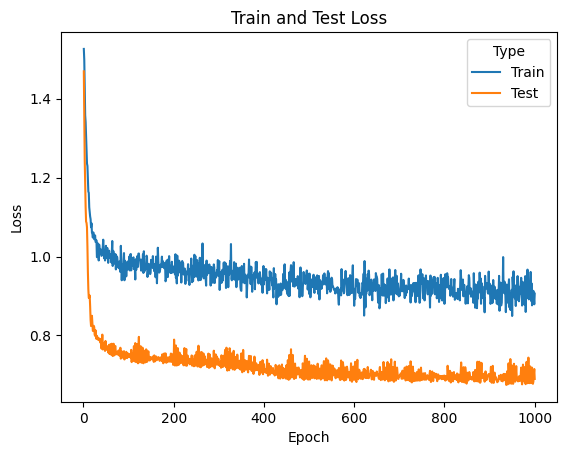

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the losses
metrics = {
    'Epoch': list(range(1, len(train_losses) + 1)) * 2,
    'Loss': train_losses + test_losses,
    'Type': ['Train'] * len(train_losses) + ['Test'] * len(test_losses)
}

data_df = pd.DataFrame(metrics)

# Plot the losses
sns.lineplot(data=data_df, x='Epoch', y='Loss', hue='Type')

plt.title('Train and Test Loss')
plt.show()

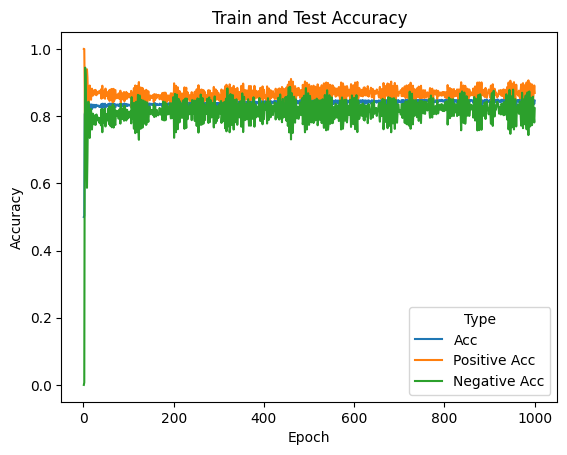

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


metrics = {
    'Epoch': list(range(1, len(test_accs) + 1)) * 3,
    'Accuracy': test_accs + test_pos_accs + test_neg_accs,
    'Type': ['Acc'] * len(test_accs) + ['Positive Acc'] * len(test_pos_accs) + ['Negative Acc'] * len(test_neg_accs)
}

data_df = pd.DataFrame(metrics)

# Plot the losses
sns.lineplot(data=data_df, x='Epoch', y='Accuracy', hue='Type')
plt.title('Test Accuracy')
plt.show()